# Prep

## Dependencies

In [2]:
# General
import os
from os import path
import shutil
import glob
from datetime import datetime
from tqdm.notebook import tqdm

# Data processing
import pandas as pd
import numpy as np

# Keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

# ScikitLearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import (accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    auc,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay)

# Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Images
import cv2

2023-04-25 21:59:15.010950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 21:59:18.176662: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-04-25 21:59:18.176877: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

## Constants

In [1]:
CLASSES = ["normal", "covid"] # In order, first = 0, then 1, etc.
NUM_EPOCHS = 80
VALID_SPLIT = 0.1 # 10% of the TEST dataset so 8% overall
TEST_SPLIT = 0.2
LABEL_COLUMN = 'label'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
RANDOM_STATE = 41
LEARNING_RATE = 1e-4
MODEL_PREFIX = "CUIEM"
OUT_MODEL_PATH = f"./{MODEL_PREFIX}-models"

## Prepare Datasets

In [3]:
# Get paths
d1_data_path = path.join(os.getcwd(), "data/d1")

d2_data_path = path.join(os.getcwd(), "data/d2")

In [4]:
def get_image_df(data_path, labels_filter=CLASSES):
    labels = os.listdir(data_path)
    columns = ["image_path", LABEL_COLUMN]
    
    images = []
    for label in labels:
        if label not in labels_filter:
            continue
        label_image_paths = os.listdir(path.join(data_path, label))
        label_images = list(map(lambda im_path: [f"{label}/{im_path}", label], label_image_paths))
        images.extend(label_images)
        
    return pd.DataFrame(images, columns=columns)
        
def split_into_train_valid_test(df, test_split=TEST_SPLIT, valid_split=VALID_SPLIT):
    # Stratify split test dataset into test and validation
    full_train_df, test_df = train_test_split(df,
                                         test_size=test_split,
                                         shuffle=True,
                                         stratify=df[LABEL_COLUMN],
                                         random_state=RANDOM_STATE
                                        )

    train_df, valid_df = train_test_split(full_train_df,
                                         test_size=valid_split,
                                         shuffle=True,
                                         stratify=full_train_df[LABEL_COLUMN],
                                         random_state=RANDOM_STATE
                                        )
    return train_df, valid_df, test_df

In [5]:
df_1 = get_image_df(d1_data_path)
df_2 = get_image_df(d2_data_path)
display(df_1.sample(5).head())
display(df_2.sample(5).head())

,image_path,label
1975,covid/COVID-1608.png,covid
4750,normal/NORMAL-7199.png,normal
1612,covid/COVID-3466.png,covid
1750,covid/COVID-2212.png,covid
297,covid/COVID-2357.png,covid


,image_path,label
242,covid/COVID-306.png,covid
1905,normal/NORMAL-9550.png,normal
1827,normal/NORMAL-10001.png,normal
337,covid/COVID-113.png,covid
806,covid/COVID-1036.png,covid


In [6]:
train_df_1, valid_df_1, test_df_1 = split_into_train_valid_test(df_1)
train_df_2, valid_df_2, test_df_2 = split_into_train_valid_test(df_2)

## Load Dataset

In [7]:
#Train datagen here is a preprocessor
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   # featurewise_center = True,
                                   # featurewise_std_normalization = True,
                                   # width_shift_range=0.2,
                                   # height_shift_range=0.2,
                                   shear_range=0.15,
                                   zoom_range=0.1,
                                   # zca_whitening = True,
                                   # channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   # vertical_flip = True ,
                                   # validation_split = 0.2,
                                   fill_mode='constant')


flow_kwargs = {
    # 'directory': train_data_path,
    'x_col': 'image_path',
    'y_col': LABEL_COLUMN,
    'batch_size': BATCH_SIZE,
    'seed': RANDOM_STATE,
    'class_mode': 'categorical',
    'classes': CLASSES,
    'target_size': IMAGE_SIZE
}

#Test Datagen only rescales for model
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


train_batches_1 = train_datagen.flow_from_dataframe(dataframe=train_df_1,
                                                  directory=d1_data_path, shuffle=True, **flow_kwargs)

valid_batches_1 = train_datagen.flow_from_dataframe(dataframe=valid_df_1,
                                                  directory=d1_data_path, shuffle=False, **flow_kwargs)

test_batches_1 = test_datagen.flow_from_dataframe(dataframe=test_df_1,
                                                directory=d1_data_path, shuffle=False, **flow_kwargs)

train_batches_2 = train_datagen.flow_from_dataframe(dataframe=train_df_2,
                                                  directory=d2_data_path, shuffle=True, **flow_kwargs)

valid_batches_2 = train_datagen.flow_from_dataframe(dataframe=valid_df_2,
                                                  directory=d2_data_path, shuffle=False, **flow_kwargs)

test_batches_2 = test_datagen.flow_from_dataframe(dataframe=test_df_2,
                                                directory=d2_data_path, shuffle=False, **flow_kwargs)

DATASETS_1 = {
    'train_1': train_batches_1,
    "validation_1": valid_batches_1,
    'test_1': test_batches_1,
}

DATASETS_2 = {
    'train_2': train_batches_2,
    "validation_2": valid_batches_2,
    'test_2': test_batches_2,
}

DATASETS = {
    **DATASETS_1,
    **DATASETS_2
}

Found 3562 validated image filenames belonging to 2 classes.
Found 396 validated image filenames belonging to 2 classes.
Found 990 validated image filenames belonging to 2 classes.
Found 1644 validated image filenames belonging to 2 classes.
Found 183 validated image filenames belonging to 2 classes.
Found 457 validated image filenames belonging to 2 classes.


# EDA

In [8]:
print(train_batches_1.class_indices)

{'normal': 0, 'covid': 1}


In [9]:
print(f"Train dataset 1 length: {len(train_df_1)}")
print(f"Valid dataset 1 length: {len(valid_df_1)}")
print(f"Test dataset 1 length: {len(test_df_1)}")

Train dataset 1 length: 3562
Valid dataset 1 length: 396
Test dataset 1 length: 990


In [10]:

print(f"Train dataset 2 length: {len(train_df_2)}")
print(f"Valid dataset 2 length: {len(valid_df_2)}")
print(f"Test dataset 2 length: {len(test_df_2)}")

Train dataset 2 length: 1644
Valid dataset 2 length: 183
Test dataset 2 length: 457


In [11]:
xb, yb = train_batches_1.next()
xb.shape,yb.shape

((32, 224, 224, 3), (32, 2))

In [12]:
xb, yb = train_batches_2.next()
xb.shape,yb.shape

((32, 224, 224, 3), (32, 2))

In [13]:
def display_class_sample(df, data_path, num_samples_per_class=3, middle_image=1):
    fig, axs = plt.subplots(2, num_samples_per_class, figsize = (6*num_samples_per_class, 3*4))

    for ax_row, (label, data) in zip(axs, df.sort_values([LABEL_COLUMN]).groupby(LABEL_COLUMN)):
        ax_row[middle_image].set_title(label, fontsize = 15)
        for ax, (idx, instance) in zip(ax_row, data.sample(num_samples_per_class).iterrows()):       
            _path = path.join(data_path, instance['image_path'])
            image = cv2.imread(_path)
            ax.imshow(image)
            ax.axis('off')

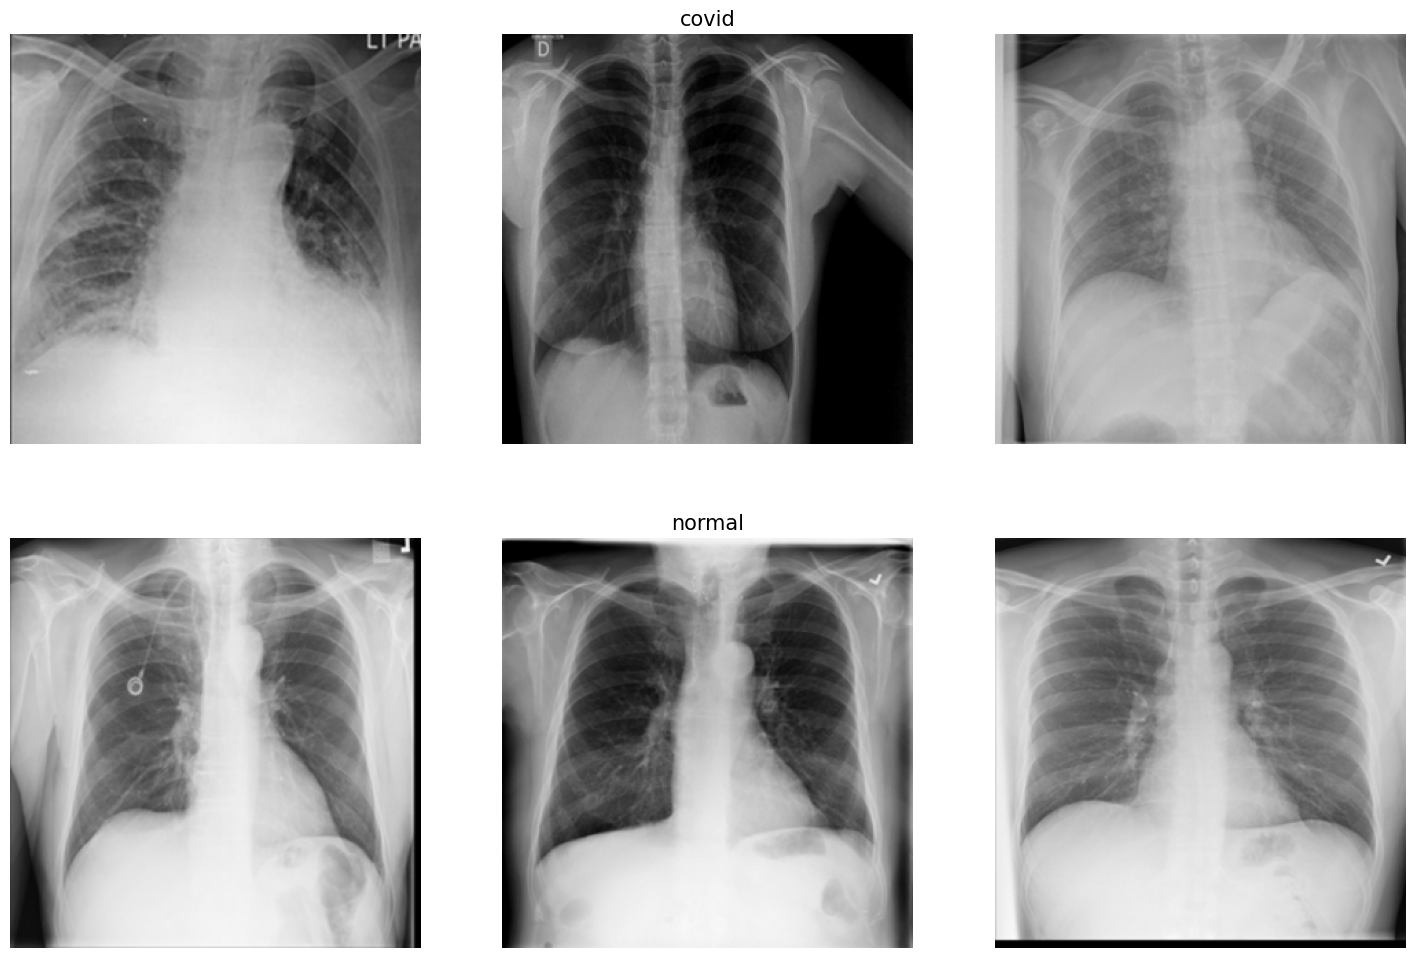

In [14]:
display_class_sample(train_df_1, d1_data_path)

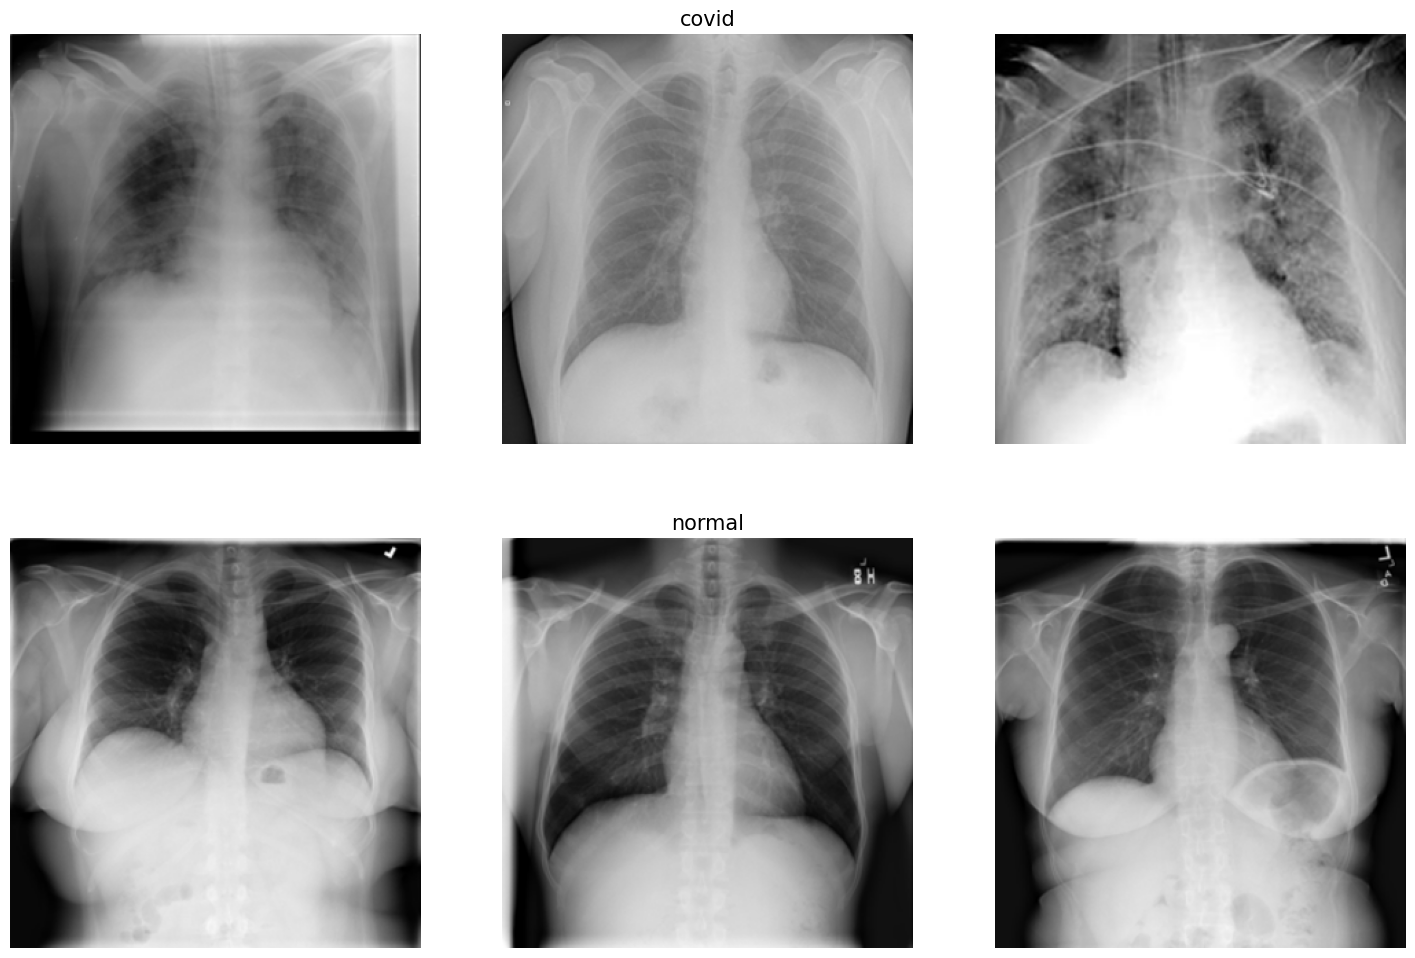

In [15]:
display_class_sample(train_df_2, d2_data_path)

# Train Model

## Build CUIEM (Ensemble of Models)

In [16]:
def build_model(model_name, summary=False):
    base_model = None
    model_map = {
        'resnet50_v2': tf.keras.applications.ResNet50V2,
        'inception_v3': tf.keras.applications.InceptionV3,
        'densenet201': tf.keras.applications.DenseNet201,
    }

    base_model = model_map[model_name](weights=None, include_top=False, input_shape= (*IMAGE_SIZE, 3))
    
    x = base_model.output         
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output = tf.keras.layers.Dense(len(CLASSES), activation=None)(x)
    model = tf.keras.Model(inputs = base_model.input, outputs = output)
    

    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

    model.compile(optimizer = optimizer,
                  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics = ['accuracy'])
    if summary:
        print(model.summary())
    return model

## Fit Model

In [41]:
def train_model_and_save_results(model, *args, name=None, out_path=OUT_MODEL_PATH, out_time=None, save_final=True, **kwargs):
    if not name:
        raise Exception("Must supply name when training multiple models")
        
    if not out_time:
        out_time = datetime.now()
    out_path = path.join(out_path, out_time.strftime("%Y-%m-%dT%H:%M"))
    os.makedirs(out_path, exist_ok=True)
    
    save_model = tf.keras.callbacks.ModelCheckpoint(
        f"{out_path}/"+ name + "-{epoch:04d}-{accuracy:.2f}.tf",
        monitor = "val_loss",
        mode='min',
        verbose=0,
        save_weights_only=True,
        save_best_only=True
    )
    history_logger = tf.keras.callbacks.CSVLogger(path.join(out_path, name+"-train-log.csv"), separator=",", append=False)
    
    callbacks=kwargs.pop("callbacks", [])
    callbacks.append(save_model)
    callbacks.append(history_logger)

    history = model.fit(callbacks=callbacks, *args, **kwargs)
    np.save(path.join(out_path, name+"-history.npy"), history.history)
    
    # Save final model
    last_accuracy = history.history['accuracy'][-1]
    final_out_path = f"{out_path}/" + name +"-last-{accuracy:.2f}.tf".format(accuracy=last_accuracy)
    model.save_weights(final_out_path)
    
    return history.history

def load_model(model, model_path, checkpoint_name, history_name="history.npy"):
    model_path = path.join(OUT_MODEL_PATH, model_path)
    checkpoint_path = path.join(model_path, checkpoint_name)
    history_path = path.join(model_path, history_name)
    model.load_weights(checkpoint_path)
    history = np.load(history_path, allow_pickle='TRUE').item()
    
def train_together():
    """
    Only used to synchronize clocks for output models into the same folder
    """
    out_time = datetime.now()
    
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, 
                           mode='min', restore_best_weights=True)]

    try:
        history_1 = train_model_and_save_results(model_1, train_batches_1,
                                 name=f"{MODEL_PREFIX}-1",
                                 out_time=out_time,
                                 validation_data=valid_batches_2,
                                 epochs=NUM_EPOCHS,
                                 workers=1,
                                 callbacks=callbacks
                            )
    except Exception as e:
        print(f"Failed to train model_1: {e}")
        
    try:
        history_2 = train_model_and_save_results(model_2, train_batches_2,
                             name=f"{MODEL_PREFIX}-2",
                             out_time=out_time,
                             validation_data=valid_batches_2,
                             epochs=NUM_EPOCHS,
                             workers=1,
                             callbacks=callbacks
                            )
    except Exception as e:
        print(f"Failed to train model_2: {e}")
    
    return history_1, history_2

In [18]:
def train_model(model, name, train_batches, valid_batches, out_time=None, **kwargs):
    history = train_model_and_save_results(model, train_batches,
                                 name=name,
                                 out_time=out_time,
                                 validation_data=valid_batches,
                                 epochs=NUM_EPOCHS,
                                 workers=1, 
                                 **kwargs)
                                 # class_weight=class_weights)
    return history

def load_model(model, model_path, checkpoint_name, history_name="history.npy"):
    model_path = path.join(OUT_MODEL_PATH, model_path)
    checkpoint_path = path.join(model_path, checkpoint_name)
    history_path = path.join(model_path, history_name)
    model.load_weights(checkpoint_path)
    history = np.load(history_path, allow_pickle='TRUE').item()
    return history
    
def train_together(train_batches, valid_batches, group):
    """
    Only used to synchronize clocks for output models into the same folder
    """
    out_time = datetime.now()
    
    try:
        inception_model = build_model('inception_v3')
        inception_history = train_model(inception_model, f"inception-{group}", train_batches, valid_batches, out_time=out_time)
    except Exception as e:
        print(f"Failed to train inception: {e}")
    
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, 
                           mode='min', restore_best_weights=True)]
    try:
        densenet_model = build_model('densenet201')
        densenet_history = train_model(densenet_model, f"densenet-{group}", train_batches, valid_batches, callbacks=callbacks, out_time=out_time)
    except Exception as e:
        print(f"Failed to train densenet: {e}")
    
    try:
        resnet_model = build_model('resnet50_v2')
        resnet_history = train_model(resnet_model, f"resnet-{group}", train_batches, valid_batches, callbacks=callbacks, out_time=out_time)
    except Exception as e:
        print(f"Failed to train resnet: {e}")
    
    return inception_model, densenet_model, resnet_model, inception_history, densenet_history, resnet_history

In [19]:
# LOAD_INCEPTION_1 = False
# inception_model_1 = build_model('inception_v3')
# if LOAD_INCEPTION_1:
#     # inception_history_1 = load_model(inception_model_1, history_name="inception-1-history.npy", xx, xx)
#     pass
# else:
#     inception_history_1 = train_model(inception_model_1, "inception-1", train_batches_1, valid_batches_1,)

In [20]:
# LOAD_DENSENET_1 = False
# densenet_model_1 = build_model('densenet201')

# if LOAD_DENSENET_1:
#     # densenet_history_1 = load_model(densenet_model_1, history_name="densenet-1-history.npy", xx, xx)
#     pass
# else:
#     early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, 
#                            mode='min', restore_best_weights=True)
#     densenet_history_1 = train_model(densenet_model_1, "densenet-1", train_batches_1, valid_batches_1, callbacks=[early_stop])

In [21]:
# LOAD_RESNET_1 = False
# resnet_model_1 = build_model('resnet50_v2')

# if LOAD_RESNET_1:
#     # resnet_history_1 = load_model(resnet_model_1, history_name="resnet-history.npy", xx, xx)
#     pass
# else:
#     early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, 
#                            mode='min', restore_best_weights=True)
#     resnet_history_1 = train_model(resnet_model_1, "resnet-1", train_batches_1, valid_batches_1, callbacks=[early_stop]) 

In [22]:
# LOAD_INCEPTION_2 = False
# inception_model_2 = build_model('inception_v3')
# if LOAD_INCEPTION_2:
#     # inception_history_2 = load_model(inception_model_2, history_name="inception-2-history.npy", xx, xx)
#     pass
# else:
#     inception_history_2 = train_model(inception_model_2, train_batches_2, valid_batches_2, "inception-2")

In [23]:
# LOAD_DENSENET_2 = False
# densenet_model_2 = build_model('densenet201')

# if LOAD_DENSENET_2:
#     # densenet_history_2 = load_model(densenet_model_2, history_name="densenet-2-history.npy", xx, xx)
#     pass
# else:
#     early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, 
#                            mode='min', restore_best_weights=True)
#     densenet_history_2 = train_model(densenet_model_2, "densenet-2", train_batches_2, valid_batches_2, callbacks=[early_stop])

In [24]:
# LOAD_RESNET_2 = False
# resnet_model_2 = build_model('resnet50_v2')

# if LOAD_RESNET_2:
#     # resnet_history_2 = load_model(resnet_model_2, history_name="resnet-2-history.npy", xx, xx)
#     pass
# else:
#     early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, 
#                            mode='min', restore_best_weights=True)
#     resnet_history_2 = train_model(resnet_model_2, "resnet-2", train_batches_2, valid_batches_2, callbacks=[early_stop]) 

In [25]:
inception_model_1, densenet_model_1, resnet_model_1, inception_history_1, densenet_history_1, resnet_history_1 = train_together(train_batches_1, valid_batches_1, "1")
inception_model_2, densenet_model_2, resnet_model_2, inception_history_2, densenet_history_2, resnet_history_2 = train_together(train_batches_2, valid_batches_2, "2")

2023-04-25 21:59:28.992313: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-25 21:59:29.004538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-25 21:59:29.004877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-25 21:59:29.005820: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Epoch 1/80


2023-04-25 21:59:52.025529: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2023-04-25 21:59:53.408944: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fe71c006800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-25 21:59:53.408992: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2023-04-25 21:59:53.418132: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-25 21:59:53.588544: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


112/112 [==============================] - 89s 445ms/step - loss: 0.5397 - accuracy: 0.7347 - val_loss: 0.9976 - val_accuracy: 0.5000
Epoch 2/80
112/112 [==============================] - 46s 407ms/step - loss: 0.4004 - accuracy: 0.8226 - val_loss: 1.6235 - val_accuracy: 0.5000
Epoch 3/80
112/112 [==============================] - 47s 417ms/step - loss: 0.3549 - accuracy: 0.8470 - val_loss: 0.6433 - val_accuracy: 0.6768
Epoch 4/80
112/112 [==============================] - 45s 405ms/step - loss: 0.3047 - accuracy: 0.8711 - val_loss: 2.4010 - val_accuracy: 0.5000
Epoch 5/80
112/112 [==============================] - 47s 419ms/step - loss: 0.2709 - accuracy: 0.8894 - val_loss: 0.5943 - val_accuracy: 0.6995
Epoch 6/80
112/112 [==============================] - 47s 419ms/step - loss: 0.2296 - accuracy: 0.9001 - val_loss: 0.3774 - val_accuracy: 0.8308
Epoch 7/80
112/112 [==============================] - 46s 406ms/step - loss: 0.2225 - accuracy: 0.9062 - val_loss: 0.4922 - val_accuracy: 0.8

# Evaluate

In [40]:
def get_pred_and_truth_not_shuffled(model, batches, single_binary_neuron=False):
    """
    This can only be used if the dataset is not shuffled
    """
    preds = model.predict(batches)
    if single_binary_neuron:
        # For single neuron with binary class probabily output
        y_pred = np.where(preds > 0.5, 1, 0)
    else:
        # For multi class or binary class using 2 neurons
        y_pred = np.argmax(preds, axis=-1)
    y_true = batches.classes
    return y_pred, y_true


def get_pred_and_truth(model, batches, single_binary_neuron=False, ensemble=False, ensemble_weights=None):
    """
    This is required if the dataset is shuffled. You can't use batches.classes as the indexes are all wrong.
    Instead you get each batch, one at a time and process 
    """
    if ensemble:
        assert type(model) is list, "Model should be list of models if testing an ensemble"
        assert ensemble_weights is not None, "Weights must be set for ensemble"
        assert len(ensemble_weights) == len(model), "One weight should be set for each model"

    # batches.reset()
    y_pred_batches = []  # store predicted labels
    y_true_batches = []  # store true labels
    if ensemble:
        for idx in tqdm(range(len(batches))):
            img_batch, y_batch = batches[idx]
            
            preds_batch_models = []
            for m in model: 
                preds_batch_models.append(m.predict(img_batch, verbose=0))
            
            # Resahep to get a shape we can average
            # Here we are transforming into a list, batch_size long
            # Each entry is num_models * num_classes
            preds_batch = []
            for image_idx in range(len(img_batch)):
                # For each image in batch
                image_preds_models = [] 
                for model_idx in range(len(model)):
                    # For each model, get prediction, [c1, c2] # potentialy c3, if more classes
                    image_preds_models.append(preds_batch_models[model_idx][image_idx])
    
                preds_batch.append(image_preds_models)
            
            # Get avarege of each modl 
            preds_batch = np.average(np.array(preds_batch), axis=1, weights=ensemble_weights)

            if single_binary_neuron:
                # For single neuron with binary class probabily output
                y_pred_batch = np.where(preds_batch > 0.5, 1, 0)
            else:
                # For multi class or binary class using 2 neurons
                y_pred_batch = np.argmax(preds_batch, axis=-1)

            y_true_batch = np.argmax(y_batch,-1)

            y_pred_batches.append(y_pred_batch)
            y_true_batches.append(y_true_batch)

    else:
        for idx in tqdm(range(len(batches))):
            img_batch, y_batch = batches[idx]

            preds_batch = model.predict(img_batch, verbose=0)

            if single_binary_neuron:
                # For single neuron with binary class probabily output
                y_pred_batch = np.where(preds_batch > 0.5, 1, 0)
            else:
                # For multi class or binary class using 2 neurons
                y_pred_batch = np.argmax(preds_batch, axis=-1)

            y_true_batch = np.argmax(y_batch,-1)


            y_pred_batches.append(y_pred_batch)
            y_true_batches.append(y_true_batch)

    y_true = tf.concat([item for item in y_true_batches], axis = 0)
    y_pred = tf.concat([item for item in y_pred_batches], axis = 0)

    return y_pred, y_true


def evaluate_metrics(name, y_pred, y_true, round_to=6, plot=True):
    # Get confusion matrix and standard metrics for display in dataframe
    # Metrics calculated with Sklearn where possible
    cm = confusion_matrix(y_true, y_pred)
    conf = ConfusionMatrixDisplay(cm)
    specificity = round((cm[0,0]/(cm[0,0] + cm[0,1])),round_to)
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
    
    metrics = []
    metrics.append(["Accuracy", round(accuracy_score(y_true, y_pred),round_to)]) 
    metrics.append(["Recall", round(recall_score(y_true, y_pred),round_to)]) # TP/P
    metrics.append(["Specificity", specificity]) # TN/N
    metrics.append(["Precision", round(precision_score(y_true, y_pred),round_to)]) # TP/TP+FP
    metrics.append(["F1 Score", round(f1_score(y_true, y_pred),round_to)]) # 2 * (precision + recall) / (precison * recall)
    metrics = pd.DataFrame(data=metrics, columns=["Metric", "Score"])

    if plot:
        print(f"\n----------------------------- Classification report for {name} dataset -----------------------------\n")
        display(metrics)
        conf.plot()
        plt.show()
        roc.plot()
        plt.show()
        
    return metrics, conf

def evaluate_on_dataset(model, dataset, dataset_name, plot=True, ensemble=False, ensemble_weights=None):
    y_pred, y_true = get_pred_and_truth(model, dataset, ensemble=ensemble, ensemble_weights=ensemble_weights)
    return evaluate_metrics(dataset_name, y_pred, y_true, plot=plot)

def evaluate_on_all_datasets(model, datasets=DATASETS, ensemble=False, ensemble_weights=None):
    for name, d in datasets.items():
        metrics, conf = evaluate_on_dataset(model, d, name, plot=True, ensemble=ensemble, ensemble_weights=ensemble_weights)

def plot_loss_accuracy_curves(history, plot=True, limit_epochs=None):
    """
    Takes history.history
    """
    fig, axes = plt.subplots(1, 2, figsize=(16,8))

    
    for metric, ax in zip(['loss', 'accuracy'], axes):
        if not limit_epochs:
            limit_epochs = len(history[metric])
        ax.plot(history[metric][:limit_epochs])
        ax.plot(history[f'val_{metric}'][:limit_epochs])
        ax.set_title(f'model {metric}')
        ax.set_ylabel(metric)
        ax.set_xlabel('epoch')
        ax.legend(['train', 'val'], loc='upper left')
    plt.show()

## Loss/Accuracy Curves for all Models

### Inception 1

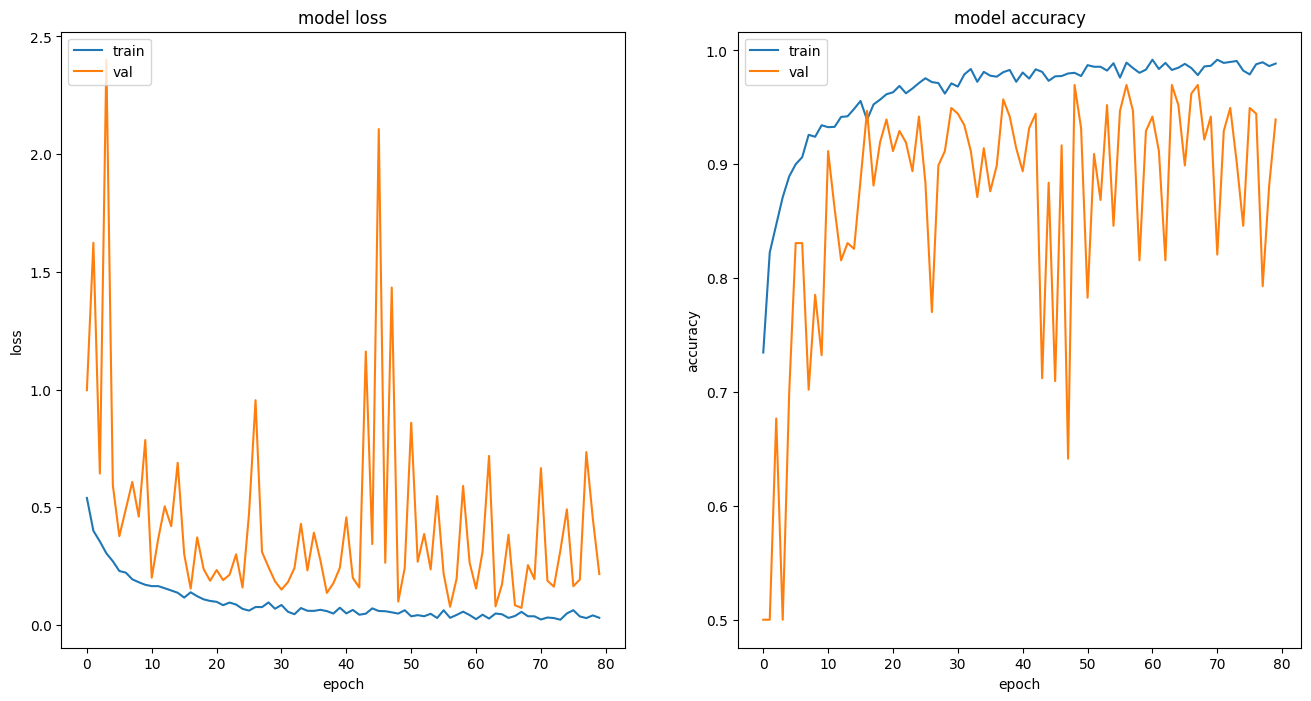

In [27]:
plot_loss_accuracy_curves(inception_history_1, plot=True)

### Inception 2

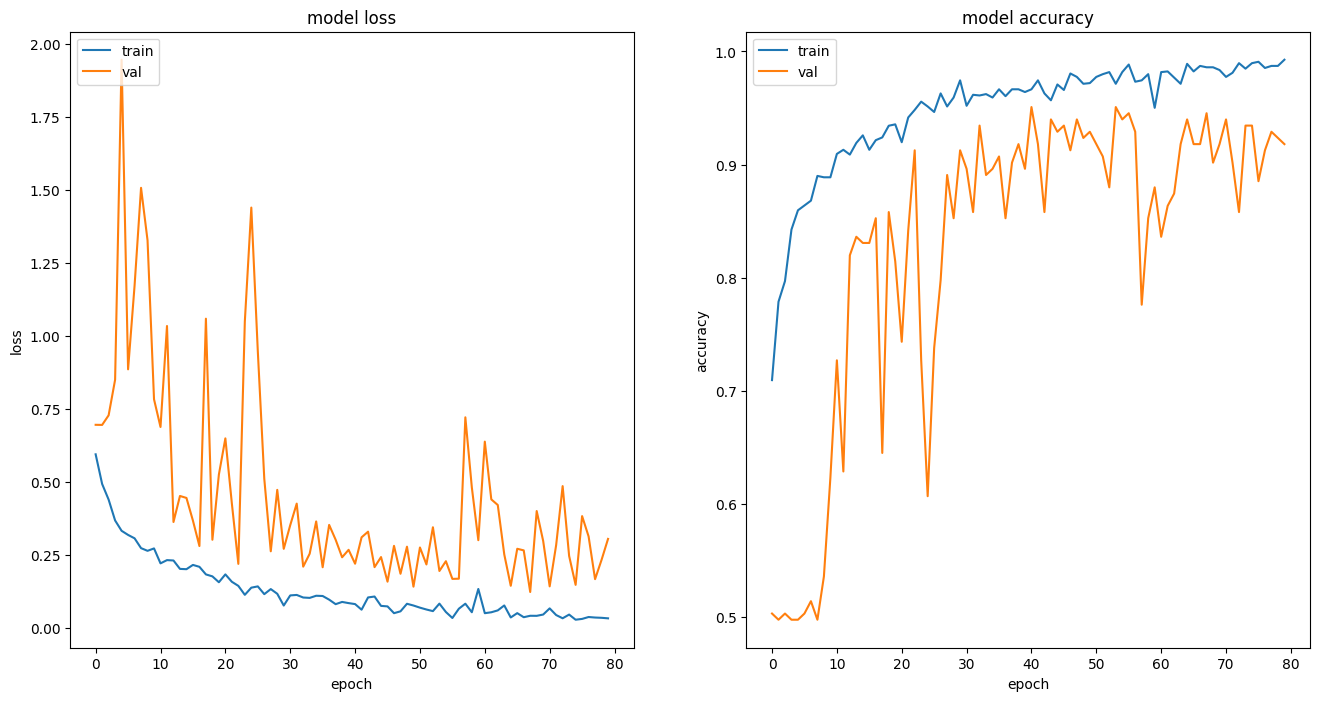

In [28]:
plot_loss_accuracy_curves(inception_history_2, plot=True)

### DenseNet 1

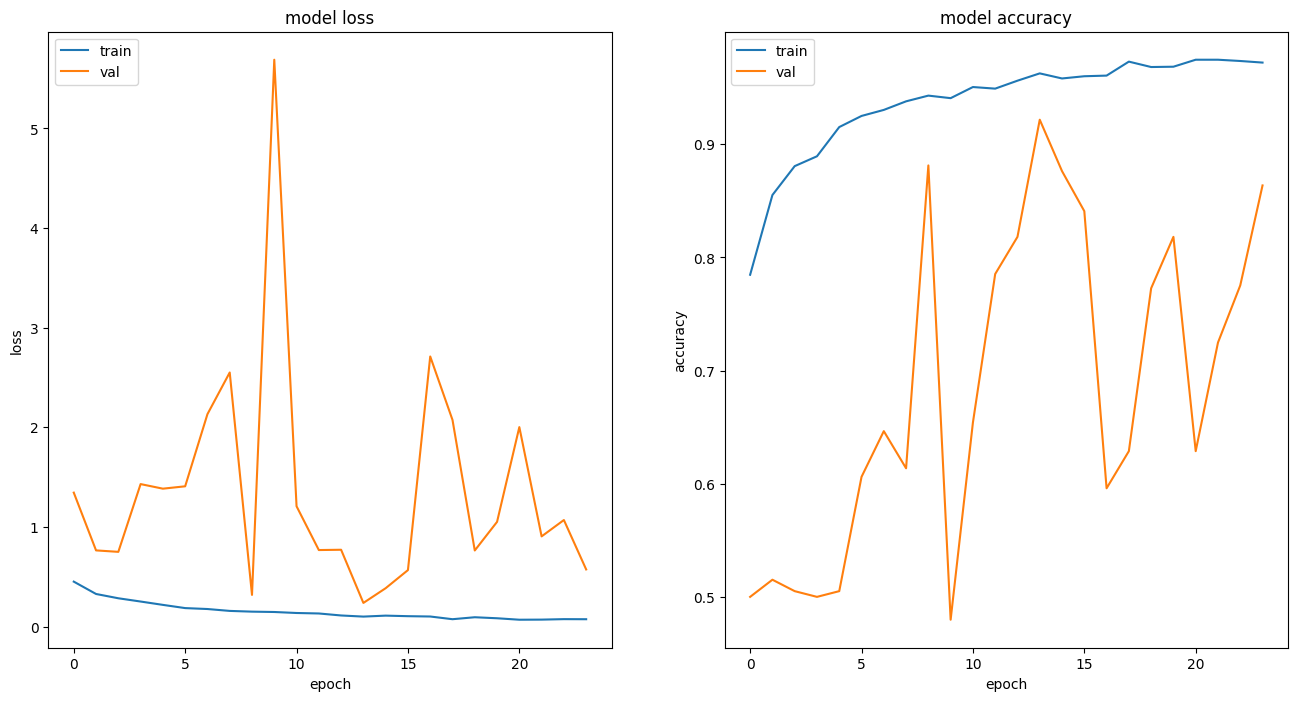

In [29]:
plot_loss_accuracy_curves(densenet_history_1, plot=True)

### DenseNet 2

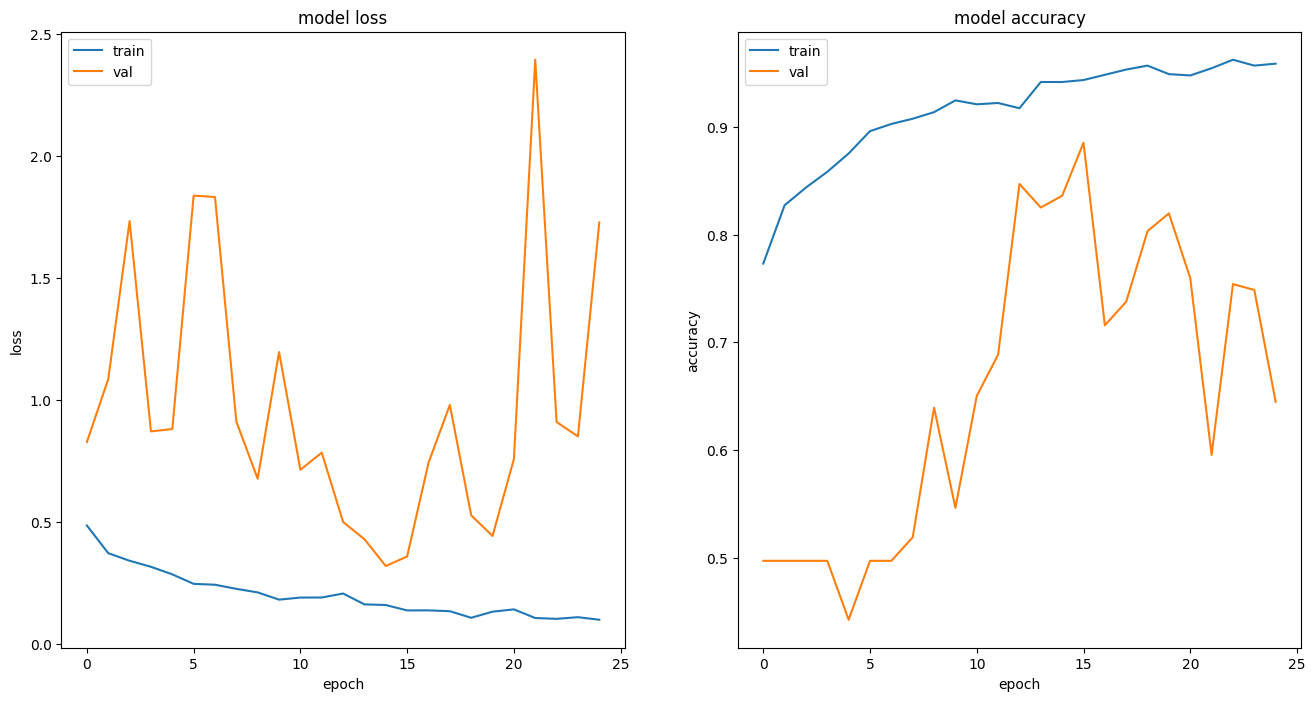

In [30]:
plot_loss_accuracy_curves(densenet_history_2, plot=True)

### ResNet 1

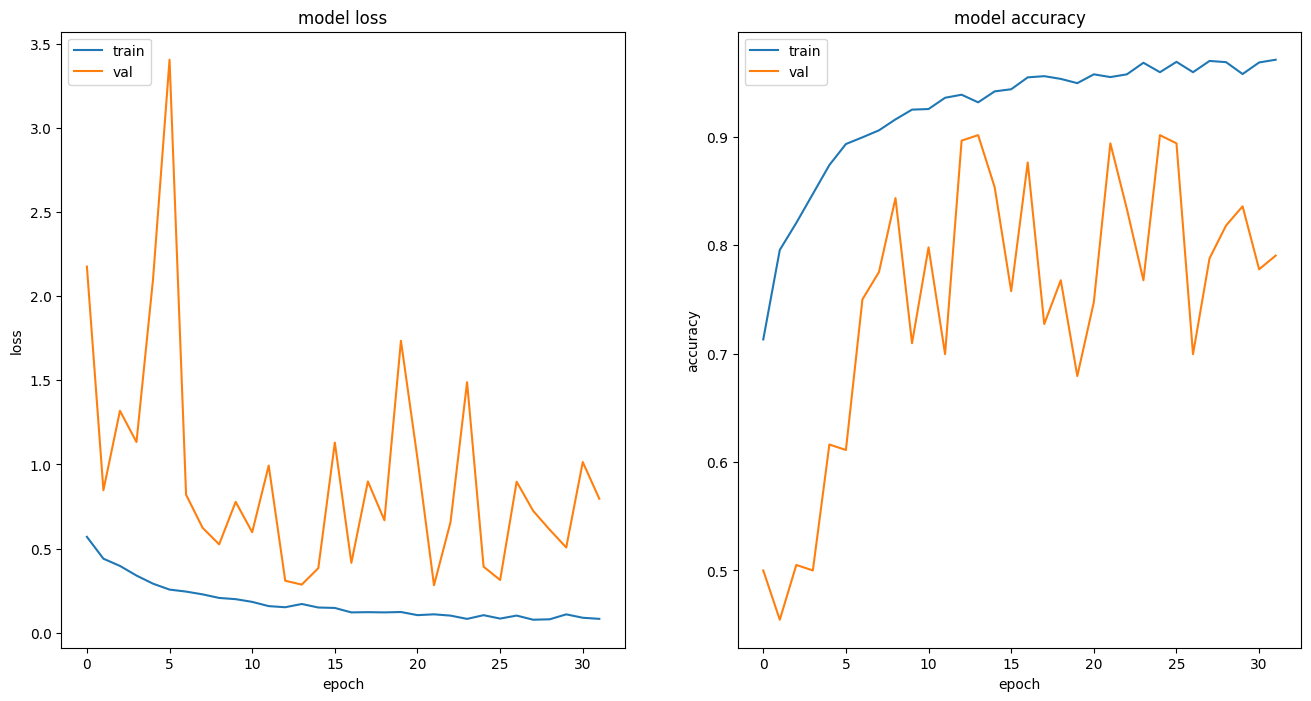

In [31]:
plot_loss_accuracy_curves(resnet_history_1, plot=True)

### ResNet 2

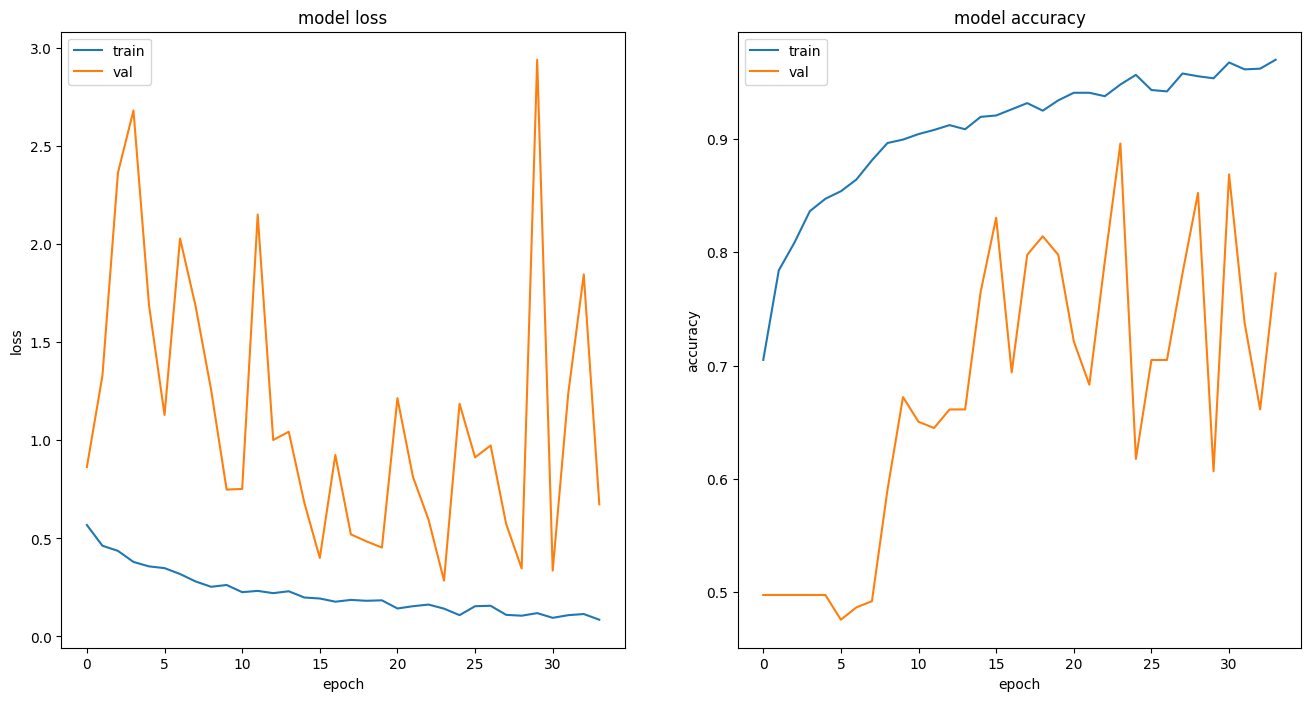

In [32]:
plot_loss_accuracy_curves(resnet_history_2, plot=True)

## Results For Ensembles 

In [33]:
def generate_weights(valid_batches, models):
    '''
    returns a list of weights
    '''
    accuracy = []
    weights = np.full((1, len(models)), 100.0)
    for model in models:
        acc = model.evaluate(valid_batches)[1]
        accuracy.append(100*acc)

    weights = weights - accuracy
    weights = weights**2
    sum = np.sum(weights)
    
    weights = weights/sum
    weights = 1/weights
    weights = weights**2

    sum = np.sum(weights)
    weights = weights/sum

    return weights

### Ensemble 1 (Trained on Dataset 1)

In [34]:
ensemble_1 = [inception_model_1, densenet_model_1, resnet_model_1]
w_1 = generate_weights(valid_batches_1, ensemble_1)[0]  # generating weights
print("Weights: ", w_1)

13/13 [==============================] - 5s 345ms/step - loss: 0.2704 - accuracy: 0.9141
Weights:  [0.71638801 0.13359393 0.15001807]


#### Dataset 1

  0%|          | 0/112 [00:00<?, ?it/s]


----------------------------- Classification report for train_1 dataset -----------------------------



,Metric,Score
0,Accuracy,0.971084
1,Recall,0.996070
2,Specificity,0.946098
3,Precision,0.948663
4,F1 Score,0.971789


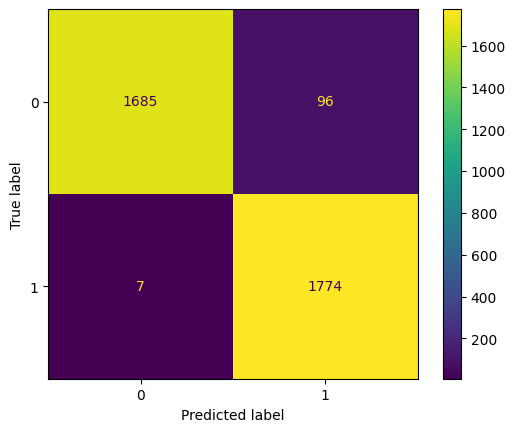

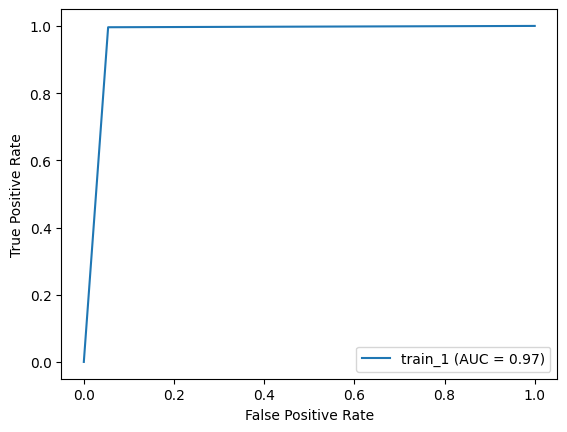

  0%|          | 0/13 [00:00<?, ?it/s]


----------------------------- Classification report for validation_1 dataset -----------------------------



,Metric,Score
0,Accuracy,0.941919
1,Recall,0.969697
2,Specificity,0.914141
3,Precision,0.918660
4,F1 Score,0.943489


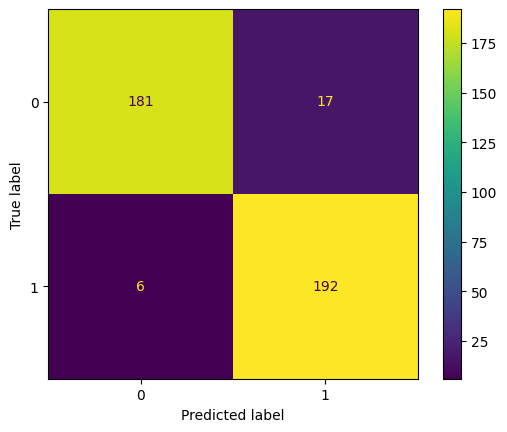

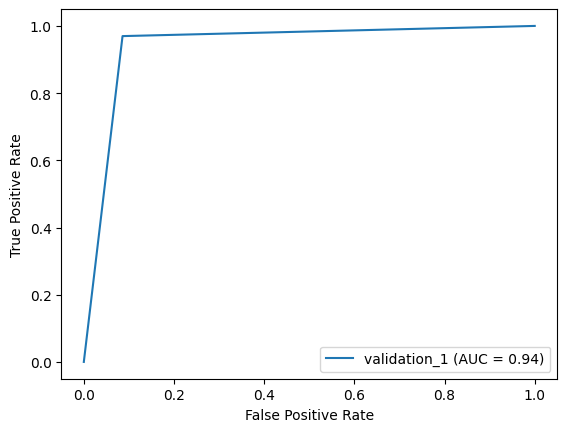

  0%|          | 0/31 [00:00<?, ?it/s]


----------------------------- Classification report for test_1 dataset -----------------------------



,Metric,Score
0,Accuracy,0.968687
1,Recall,0.971717
2,Specificity,0.965657
3,Precision,0.965863
4,F1 Score,0.968781


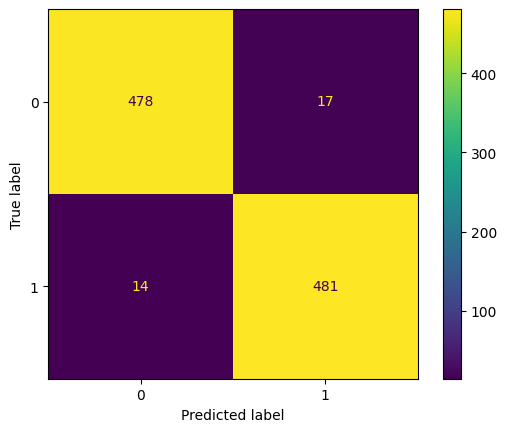

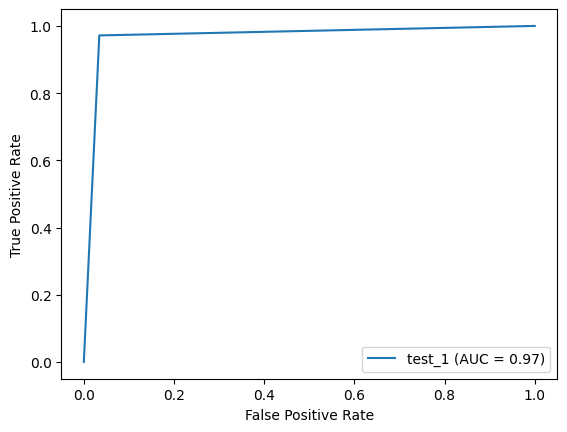

In [35]:
evaluate_on_all_datasets(ensemble_1, datasets=DATASETS_1, ensemble=True, ensemble_weights=w_1)

#### Dataset 2

  0%|          | 0/52 [00:00<?, ?it/s]


----------------------------- Classification report for train_2 dataset -----------------------------



,Metric,Score
0,Accuracy,0.920925
1,Recall,0.941606
2,Specificity,0.900243
3,Precision,0.904206
4,F1 Score,0.922527


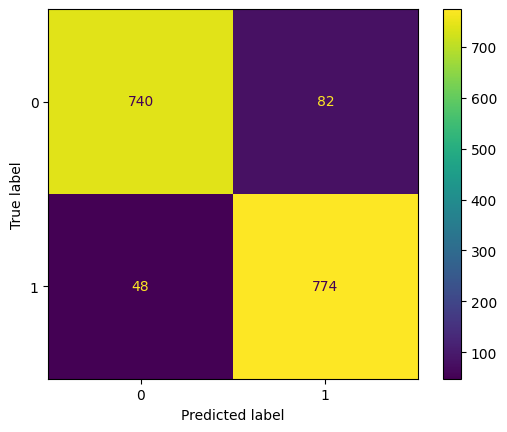

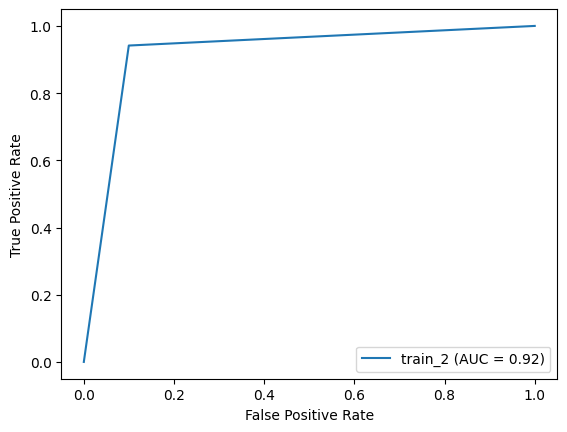

  0%|          | 0/6 [00:00<?, ?it/s]


----------------------------- Classification report for validation_2 dataset -----------------------------



,Metric,Score
0,Accuracy,0.950820
1,Recall,0.989011
2,Specificity,0.913043
3,Precision,0.918367
4,F1 Score,0.952381


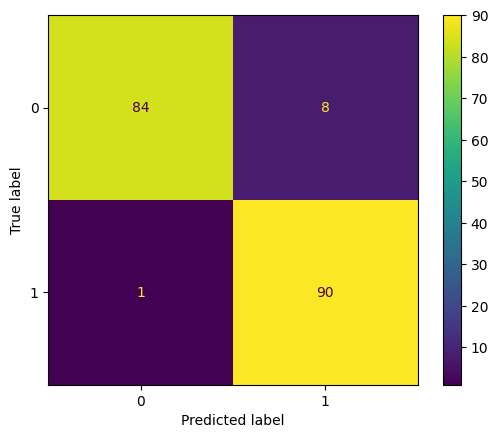

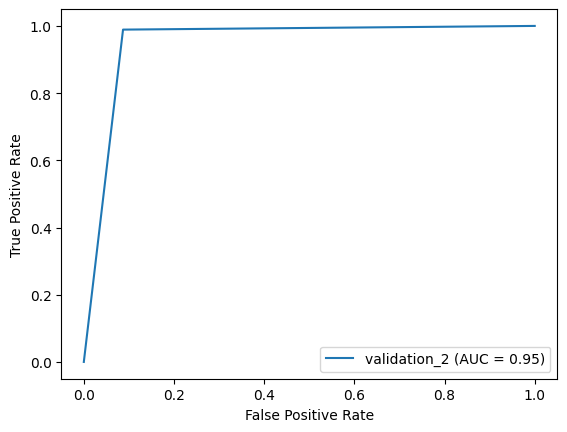

  0%|          | 0/15 [00:00<?, ?it/s]


----------------------------- Classification report for test_2 dataset -----------------------------



,Metric,Score
0,Accuracy,0.923414
1,Recall,0.899563
2,Specificity,0.947368
3,Precision,0.944954
4,F1 Score,0.921700


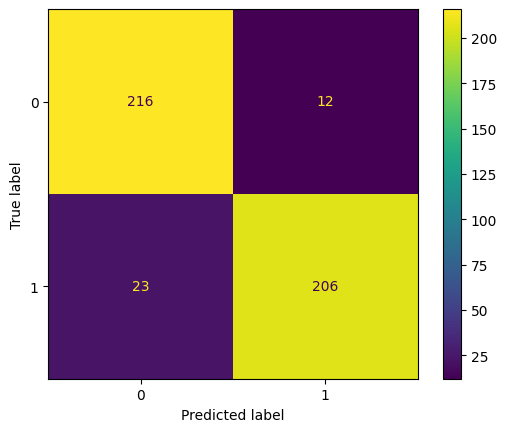

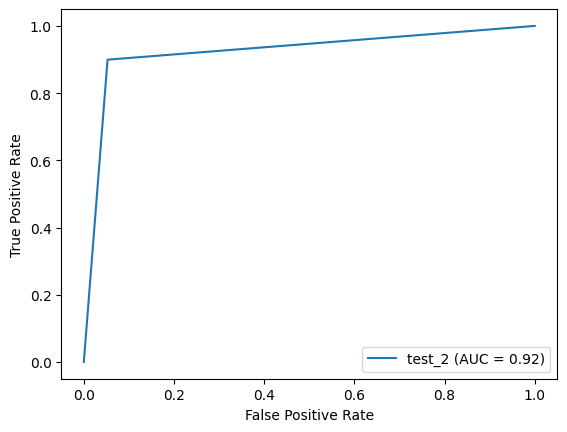

In [36]:
evaluate_on_all_datasets(ensemble_1, datasets=DATASETS_2, ensemble=True, ensemble_weights=w_1)

## Ensemble 2 (Trained on Dataset 2)

In [37]:
ensemble_2 = [inception_model_2, densenet_model_2, resnet_model_2]
w_2 = generate_weights(valid_batches_2, ensemble_2)[0]  # generating weights
print("Weights: ", w_2)

6/6 [==============================] - 2s 346ms/step - loss: 0.2568 - accuracy: 0.8962
Weights:  [0.73149343 0.0528771  0.21562946]


#### Dataset 2

  0%|          | 0/52 [00:00<?, ?it/s]


----------------------------- Classification report for train_2 dataset -----------------------------



,Metric,Score
0,Accuracy,0.982968
1,Recall,0.998783
2,Specificity,0.967153
3,Precision,0.968160
4,F1 Score,0.983234


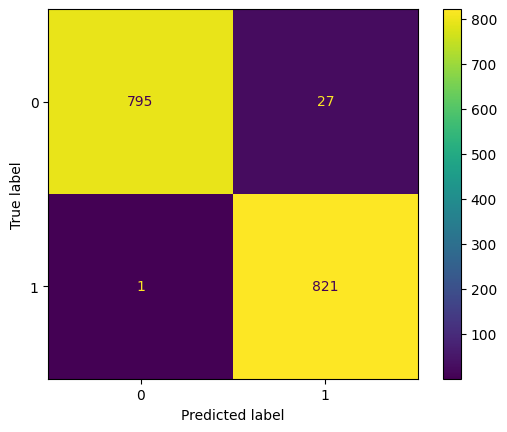

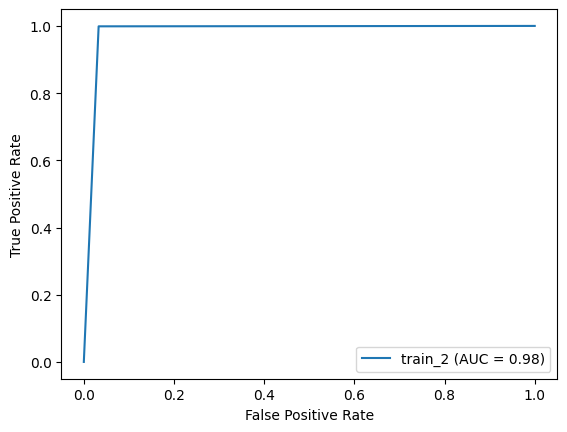

  0%|          | 0/6 [00:00<?, ?it/s]


----------------------------- Classification report for validation_2 dataset -----------------------------



,Metric,Score
0,Accuracy,0.945355
1,Recall,1.000000
2,Specificity,0.891304
3,Precision,0.900990
4,F1 Score,0.947917


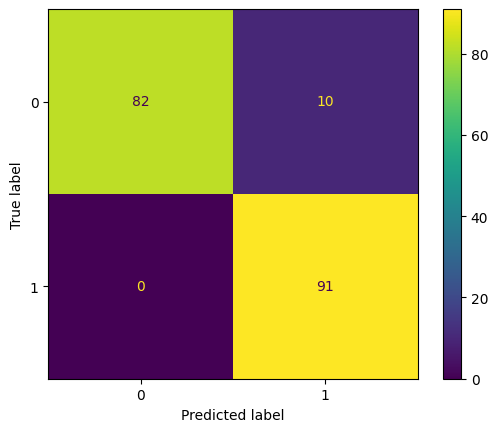

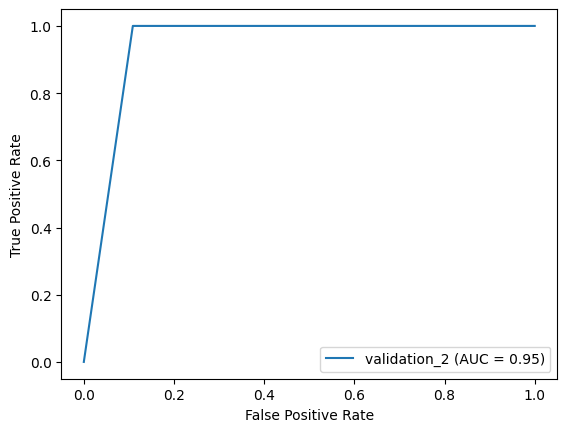

  0%|          | 0/15 [00:00<?, ?it/s]


----------------------------- Classification report for test_2 dataset -----------------------------



,Metric,Score
0,Accuracy,0.945295
1,Recall,0.947598
2,Specificity,0.942982
3,Precision,0.943478
4,F1 Score,0.945534


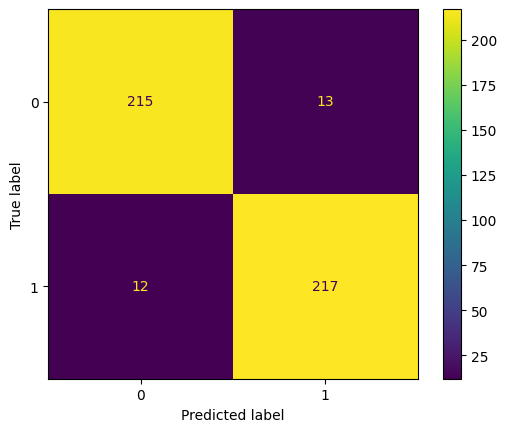

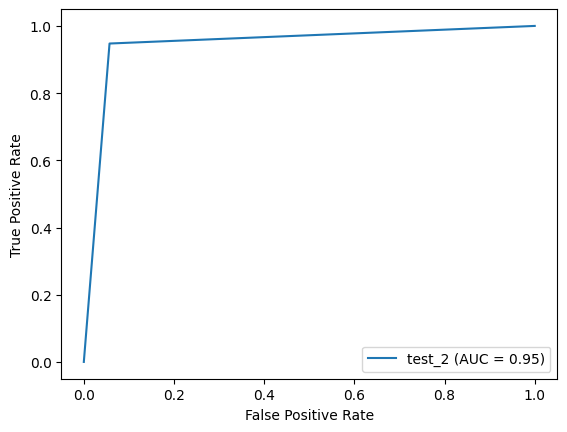

In [38]:
evaluate_on_all_datasets(ensemble_2, datasets=DATASETS_2, ensemble=True, ensemble_weights=w_2)

#### Dataset 1

  0%|          | 0/112 [00:00<?, ?it/s]


----------------------------- Classification report for train_1 dataset -----------------------------



,Metric,Score
0,Accuracy,0.828748
1,Recall,0.901741
2,Specificity,0.755755
3,Precision,0.786869
4,F1 Score,0.840398


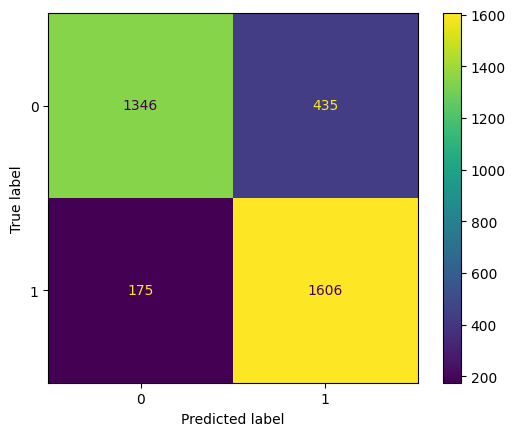

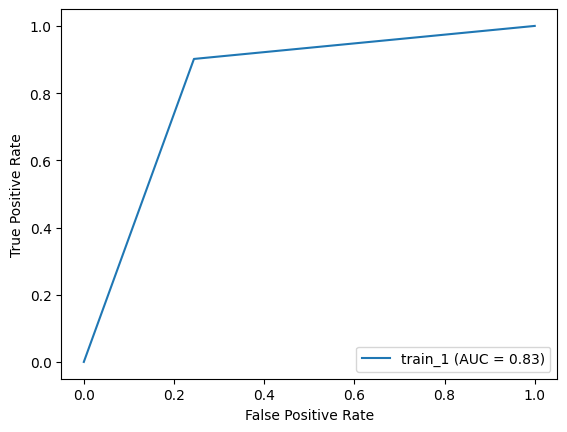

  0%|          | 0/13 [00:00<?, ?it/s]


----------------------------- Classification report for validation_1 dataset -----------------------------



,Metric,Score
0,Accuracy,0.825758
1,Recall,0.878788
2,Specificity,0.772727
3,Precision,0.794521
4,F1 Score,0.834532


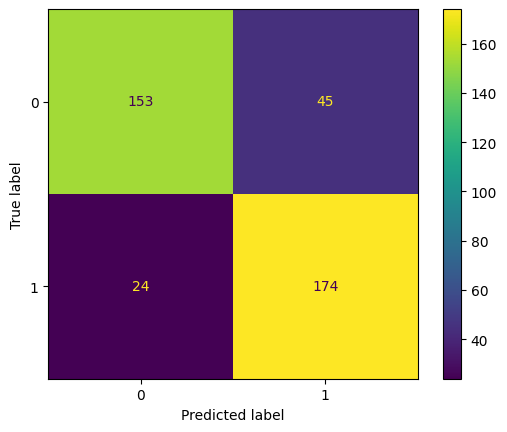

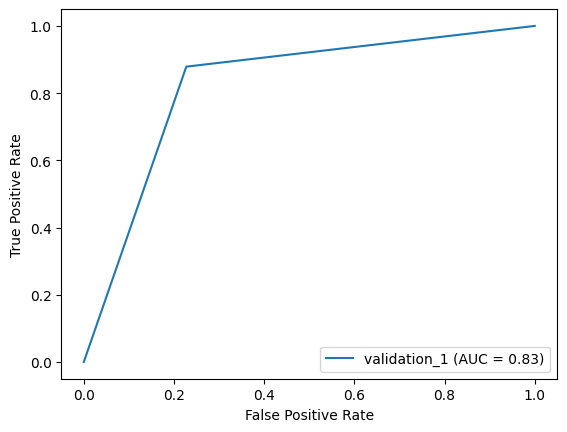

  0%|          | 0/31 [00:00<?, ?it/s]


----------------------------- Classification report for test_1 dataset -----------------------------



,Metric,Score
0,Accuracy,0.849495
1,Recall,0.894949
2,Specificity,0.804040
3,Precision,0.820370
4,F1 Score,0.856039


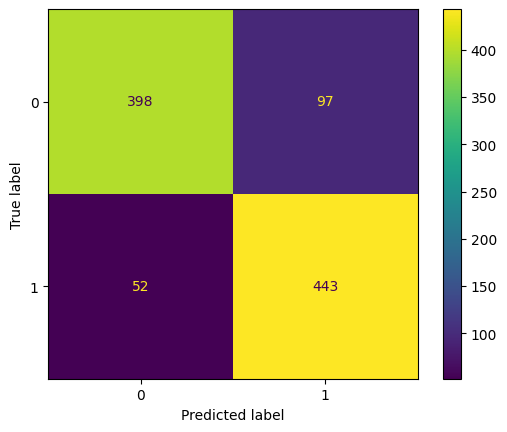

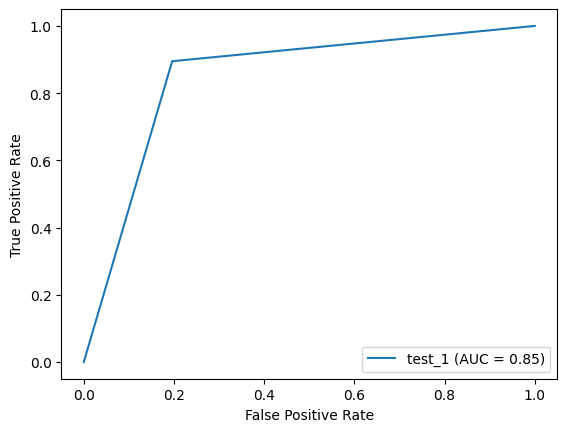

In [39]:
evaluate_on_all_datasets(ensemble_2, datasets=DATASETS_1, ensemble=True, ensemble_weights=w_2)